In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

from model import Generator
from dataset import EmbedImagePairs
from train import train, test, synthesize

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
model = Generator(1024).to(device)

trn_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/train_avg', size=64, n_hidden=1024), batch_size=200, shuffle=True)
dataloader_dict = {'train': trn_dataloader}

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [3]:
!rm -r "models/pytorch/1024"
!mkdir -p "models/pytorch/1024"

In [4]:
num_epochs=150

train(model, dataloader_dict, criterion, optimizer, device, out_name='models/pytorch/1024/model', num_epochs=num_epochs)

  7%|▋         | 10/150 [00:20<04:47,  2.05s/it]

saving


 13%|█▎        | 20/150 [00:40<04:30,  2.08s/it]

saving


 20%|██        | 30/150 [01:01<04:10,  2.09s/it]

saving


 27%|██▋       | 40/150 [01:21<03:47,  2.07s/it]

saving


 33%|███▎      | 50/150 [01:41<03:26,  2.07s/it]

saving


 40%|████      | 60/150 [02:02<03:05,  2.06s/it]

saving


 47%|████▋     | 70/150 [02:22<02:48,  2.10s/it]

saving


 53%|█████▎    | 80/150 [02:43<02:24,  2.07s/it]

saving


 60%|██████    | 90/150 [03:03<02:04,  2.07s/it]

saving


 67%|██████▋   | 100/150 [03:23<01:43,  2.07s/it]

saving


 73%|███████▎  | 110/150 [03:44<01:24,  2.12s/it]

saving


 80%|████████  | 120/150 [04:04<01:02,  2.08s/it]

saving


 87%|████████▋ | 130/150 [04:25<00:41,  2.07s/it]

saving


 93%|█████████▎| 140/150 [04:45<00:20,  2.06s/it]

saving


100%|██████████| 150/150 [05:05<00:00,  2.09s/it]

saving
saving


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore

In [6]:
trn_losses = np.load('models/pytorch/128_avg/modeltrn_losses.npy')

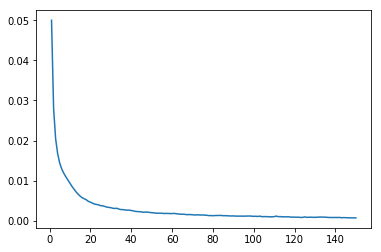

In [7]:
sns.lineplot(x=range(1, num_epochs+1), y=trn_losses)

In [8]:
data = torch.load(f"models/pytorch/1024/model_150.pth")

model = Generator(1024).to(device)
model.eval()

model.load_state_dict(data["model_state_dict"])

In [12]:
test_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/test', size=64, n_hidden=128, train=False), batch_size=100)

In [15]:
!rm -r "models/pytorch/1024/test_synth"
!mkdir -p "models/pytorch/1024/test_synth"

test_images, names = synthesize(model, test_dataloader, device)

for image, name in zip(test_images, names):
    plt.imsave("models/pytorch/1024/test_synth/" + (name.split("/")[-1]).replace('.npy', '.jpg'), image)

In [1]:
!pip install clarifai --upgrade

    100% |████████████████████████████████| 112kB 4.5MB/s 
Requirement not upgraded as not directly required: future<2,>=0.15 in /usr/local/lib/python3.6/site-packages (from clarifai) (0.16.0)
Requirement not upgraded as not directly required: requests<3,>=2.13 in /usr/local/lib/python3.6/site-packages (from clarifai) (2.19.1)
Requirement not upgraded as not directly required: jsonschema<3,>=2.5 in /usr/local/lib/python3.6/site-packages (from clarifai) (2.6.0)
Requirement not upgraded as not directly required: grpcio<2,>=1.13.0 in /usr/local/lib/python3.6/site-packages (from clarifai) (1.17.1)
Requirement not upgraded as not directly required: protobuf<4,>=3.6 in /usr/local/lib/python3.6/site-packages (from clarifai) (3.6.1)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /usr/local/lib/python3.6/site-packages (from requests<3,>=2.13->clarifai) (3.0.4)
Requirement not upgraded as not directly required: urllib3<1.24,>=1.21.1 in /usr/local/lib/python3.6/site-p

In [4]:
import glob 

from clarifai.rest import ClarifaiApp
from tqdm import tqdm

app = ClarifaiApp(api_key='f62654cf37474237b53259ab74527149')
model = app.models.get("d02b4508df58432fbb84e800597b8959")

for fname in tqdm(glob.glob('models/pytorch/1024/test_synth/*.jpg')):
    annot = model.predict_by_filename(fname)
    embed = np.array(annot["outputs"][0]["data"]["regions"][0]["data"]["embeddings"][0]["vector"])
    
    np.save(fname.replace('.jpg', '.npy'), embed)

100%|██████████| 108/108 [00:26<00:00,  4.09it/s]


In [4]:
true_vecs = sorted(glob.glob('models/pytorch/1024/test_synth/*.npy'))
synth_vecs = sorted(glob.glob('/floyd/input/data/1024dim/test/*.npy'))

In [5]:
# from https://stackoverflow.com/questions/26554211/numpy-shuffle-with-constraint

def random_derangement(n):
    while True:
        v = np.arange(n)
        for j in np.arange(n - 1, -1, -1):
            p = np.random.randint(0, j+1)
            if v[p] == j:
                break
            else:
                v[j], v[p] = v[p], v[j]
        else:
            if v[0] != 0:
                return v

In [6]:
test_dists = []

for true, synth in zip(true_vecs, synth_vecs):
    true = np.load(true)
    synth = np.load(synth)
    
    dist = np.linalg.norm(true - synth)
    test_dists += [dist]
    
random_dists = []

synth_shuffled = np.array(synth_vecs)[random_derangement(len(synth_vecs))]

for true, synth in zip(true_vecs, synth_shuffled):
    true = np.load(true)
    synth = np.load(synth)
    
    dist = np.linalg.norm(true - synth)
    random_dists += [dist]

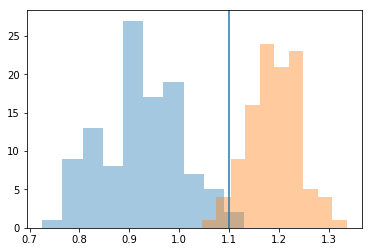

In [7]:
sns.distplot(test_dists, kde=False)
sns.distplot(random_dists, kde=False)
plt.axvline(x=1.1)
plt.show()

In [8]:
pct = percentileofscore(test_dists, 1.1)
err_pct = percentileofscore(random_dists, 1.1)
mean = np.mean(test_dists)

print("At threshold 1.1, percent of synthesized images classified as same person", pct)
print("Average distance (test):", mean)

At threshold 1.1, percent of synthesized images classified as same person 98.14814814814815
Average distance (test): 0.9233642197923527


In [9]:
vis_dataloader = DataLoader(EmbedImagePairs('/floyd/input/data/1024dim/vis', size=64, n_hidden=1024, train=False), batch_size=8)

In [10]:
vis_images, names = synthesize(model, vis_dataloader, device)

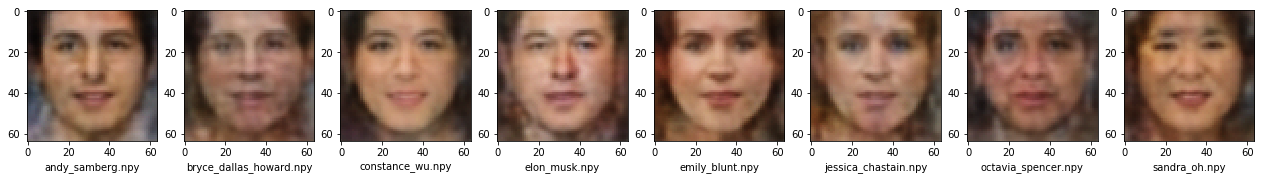

In [11]:
fig, ax = plt.subplots(1,len(vis_images))
fig.set_size_inches(22, 3)

for i in range(len(vis_images)):
    image, name = vis_images[i], names[i]
    ax[i].imshow(image)
    ax[i].set_xlabel(name.split("/")[-1])